In [17]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm


In [18]:
file_path = "../data/dataset.csv"
df = pd.read_csv(file_path)
df.head()

,datehour,station,lat,lon,name,cluster,reconstructed,disabled,capacity,bikes,delta,hour,weekday,weekend,holiday,preholiday,temp,precip,gel,vent
0,2024-12-05 00:00:00,35600927,48.863937,2.276595,Mairie du 16ème,35,True,False,34,2,1,0,3,0,0,0,5.6,0.0,0,1.8
1,2024-12-05 00:00:00,18523627466,48.923307,2.384729,Suzanne Masson,28,True,False,36,3,1,0,3,0,0,0,5.6,0.0,0,1.8
2,2024-12-05 00:00:00,101024234,48.828375,2.384274,Quai Panhard et Levassor,30,True,False,57,5,0,0,3,0,0,0,5.6,0.0,0,1.8
3,2024-12-05 00:00:00,6354,48.820507,2.351342,Gouthière - Poterne des Peupliers,5,True,False,33,1,0,0,3,0,0,0,5.6,0.0,0,1.8
4,2024-12-05 00:00:00,486750405,48.897918,2.336487,Ney - Porte de Montmartre,33,True,False,18,3,1,0,3,0,0,0,5.6,0.0,0,1.8


In [19]:
df['datehour'] = pd.to_datetime(df['datehour'])

df_prophet = df.rename(columns={'datehour': 'ds', 'delta': 'y'})

df_prophet['hour'] = df_prophet['ds'].dt.hour
df_prophet['day'] = df_prophet['ds'].dt.day
df_prophet['month'] = df_prophet['ds'].dt.month
df_prophet['dayofweek'] = df_prophet['ds'].dt.dayofweek
df_prophet['weekday'] = (df_prophet['ds'].dt.dayofweek < 5).astype(int)
df_prophet['weekend'] = (df_prophet['ds'].dt.dayofweek >= 5).astype(int)

# Aggregate data by cluster and timestamp (sum of deltas per hour per cluster)
df_prophet = df_prophet.groupby(['ds', 'cluster']).agg({
    'y': 'sum',              # Sum of deltas across all stations in the cluster
    'temp': 'mean',          # Average weather conditions
    'precip': 'mean',
    'gel': 'mean',
    'vent': 'mean',
    'hour': 'first',         # Keep the first value (same for the same timestamp)
    'day': 'first',
    'month': 'first',
    'dayofweek': 'first',
    'weekday': 'first',
    'weekend': 'first'
}).reset_index()


In [20]:
def train_by_cluster(df, cluster_id, prediction_period=7*24):
    """
    Train a Prophet model for a specific cluster using time-based train/test split.
    
    Args:
        df: Preprocessed DataFrame (aggregated by cluster)
        cluster_id: ID of the cluster to predict
        prediction_period: Number of hours to predict (default is 7 days)

    Returns:
        model: Trained Prophet model
        forecast: Forecasted values
        mae: Mean Absolute Error
        rmse: Root Mean Squared Error
    """
    # Filter the DataFrame for the selected cluster
    df_cluster = df[df['cluster'] == cluster_id].copy()

    if len(df_cluster) == 0:
        print(f"No data found for cluster {cluster_id}")
        return None, None, None, None

    df_train, df_test = train_test_split(df_cluster, test_size=0.2, shuffle=False)
    print(f"Training on {len(df_train)} rows, Testing on {len(df_test)} rows.")

    regressors = ['temp', 'precip', 'gel', 'vent', 'weekday', 'weekend', 'hour']
    available_regressors = [r for r in regressors if r in df_train.columns]

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode='multiplicative',
        interval_width=0.95,
    )

    # Add regressors to the model
    for reg in available_regressors:
        model.add_regressor(reg)

    required_columns = ['ds', 'y'] + available_regressors
    df_train_prophet = df_train[required_columns].copy()

    model.fit(df_train_prophet)

    # Create future dataframe
    future = model.make_future_dataframe(periods=prediction_period, freq='H')

    for reg in available_regressors:
        future[reg] = df_cluster[reg].reindex(future.index, method='ffill').fillna(df_train[reg].mean())

        if reg == 'hour':
            future[reg] = future['ds'].dt.hour
        elif reg == 'weekday':
            future[reg] = (future['ds'].dt.dayofweek < 5).astype(int)
        elif reg == 'weekend':
            future[reg] = (future['ds'].dt.dayofweek >= 5).astype(int)

    # Make predictions
    forecast = model.predict(future)

    forecast_test = forecast[forecast['ds'].isin(df_test['ds'])]

    if len(forecast_test) != len(df_test):
        print(f"Warning: test size mismatch. Forecast: {len(forecast_test)}, Test: {len(df_test)}")
        df_test = df_test[df_test['ds'].isin(forecast_test['ds'])]

    y_true = df_test['y'].values
    y_pred = forecast_test['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return model, forecast, mae, rmse


def plot_predictions(df_cluster, forecast, cluster_id):
    """
    Visualize predictions for a specific cluster
    """
    plt.figure(figsize=(12, 8))

    # Plot actual values
    plt.plot(df_cluster['ds'], df_cluster['y'], 'ko', markersize=2, label='Actual')

    # Plot predicted values
    plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')

    # Plot confidence interval
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                     color='blue', alpha=0.2, label='95% Confidence Interval')

    plt.title(f'Velib delta prediction - Cluster {cluster_id}')
    plt.xlabel('Date')
    plt.ylabel('Delta (total per cluster)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    return plt


def analyze_components(model, forecast):
    """
    Plot Prophet model components
    """
    fig = model.plot_components(forecast)
    return fig


def train_multiple_clusters(df, clusters=None, top_n=5):
    """
    Train Prophet models on several clusters
    
    Args:
        df: Preprocessed DataFrame (aggregated by cluster)
        clusters: List of cluster IDs to train on (if None, use top_n most active)
        top_n: How many of the most active clusters to use (if clusters is None)
    
    Returns:
        results: Dictionary containing results for each cluster
    """
    if clusters is None:
        df['y_abs'] = df['y'].abs()
        cluster_counts = df.groupby('cluster')['y_abs'].sum().sort_values(ascending=False)
        clusters = cluster_counts.head(top_n).index.tolist()

    results = {}

    for cluster_id in tqdm(clusters, desc="Training Prophet models"):
        model, forecast, mae, rmse = train_by_cluster(df, cluster_id)

        if model is not None:
            results[cluster_id] = {
                'model': model,
                'forecast': forecast,
                'mae': mae,
                'rmse': rmse
            }

            print(f"Cluster {cluster_id}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")

    return results


def compare_model_performance(results):
    """
    Compare Prophet model performance across clusters
    """
    clusters = list(results.keys())
    mae_values = [results[c]['mae'] for c in clusters]
    rmse_values = [results[c]['rmse'] for c in clusters]

    metrics_df = pd.DataFrame({
        'Cluster': clusters,
        'MAE': mae_values,
        'RMSE': rmse_values
    })

    # Sort by MAE
    metrics_df = metrics_df.sort_values('MAE')

    # Plot performance metrics
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    sns.barplot(x='Cluster', y='MAE', data=metrics_df)
    plt.title('Mean Absolute Error (MAE) by Cluster')
    plt.xticks(rotation=45)

    plt.subplot(2, 1, 2)
    sns.barplot(x='Cluster', y='RMSE', data=metrics_df)
    plt.title('Root Mean Squared Error (RMSE) by Cluster')
    plt.xticks(rotation=45)

    plt.tight_layout()
    return plt, metrics_df


Training Prophet models:   0%|          | 0/5 [00:00<?, ?it/s]

Training on 1881 rows, Testing on 471 rows.


17:13:32 - cmdstanpy - INFO - Chain [1] start processing
17:13:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
Training Prophet models:  20%|██        | 1/5 [00:01<00:04,  1.09s/it]

Cluster 50: MAE = 51.35, RMSE = 72.12
Training on 1881 rows, Testing on 471 rows.


17:13:33 - cmdstanpy - INFO - Chain [1] start processing
17:13:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
Training Prophet models:  40%|████      | 2/5 [00:01<00:02,  1.20it/s]

Cluster 23: MAE = 37.02, RMSE = 47.52
Training on 1881 rows, Testing on 471 rows.


17:13:34 - cmdstanpy - INFO - Chain [1] start processing
17:13:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
Training Prophet models:  60%|██████    | 3/5 [00:02<00:01,  1.15it/s]

Cluster 44: MAE = 36.50, RMSE = 47.22
Training on 1881 rows, Testing on 471 rows.


17:13:35 - cmdstanpy - INFO - Chain [1] start processing
17:13:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
Training Prophet models:  80%|████████  | 4/5 [00:03<00:00,  1.13it/s]

Cluster 42: MAE = 26.24, RMSE = 37.03
Training on 1881 rows, Testing on 471 rows.


17:13:36 - cmdstanpy - INFO - Chain [1] start processing
17:13:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
Training Prophet models: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]

Cluster 10: MAE = 36.58, RMSE = 51.16



c:\Users\Louise\miniconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behav

Analysis completed successfully!


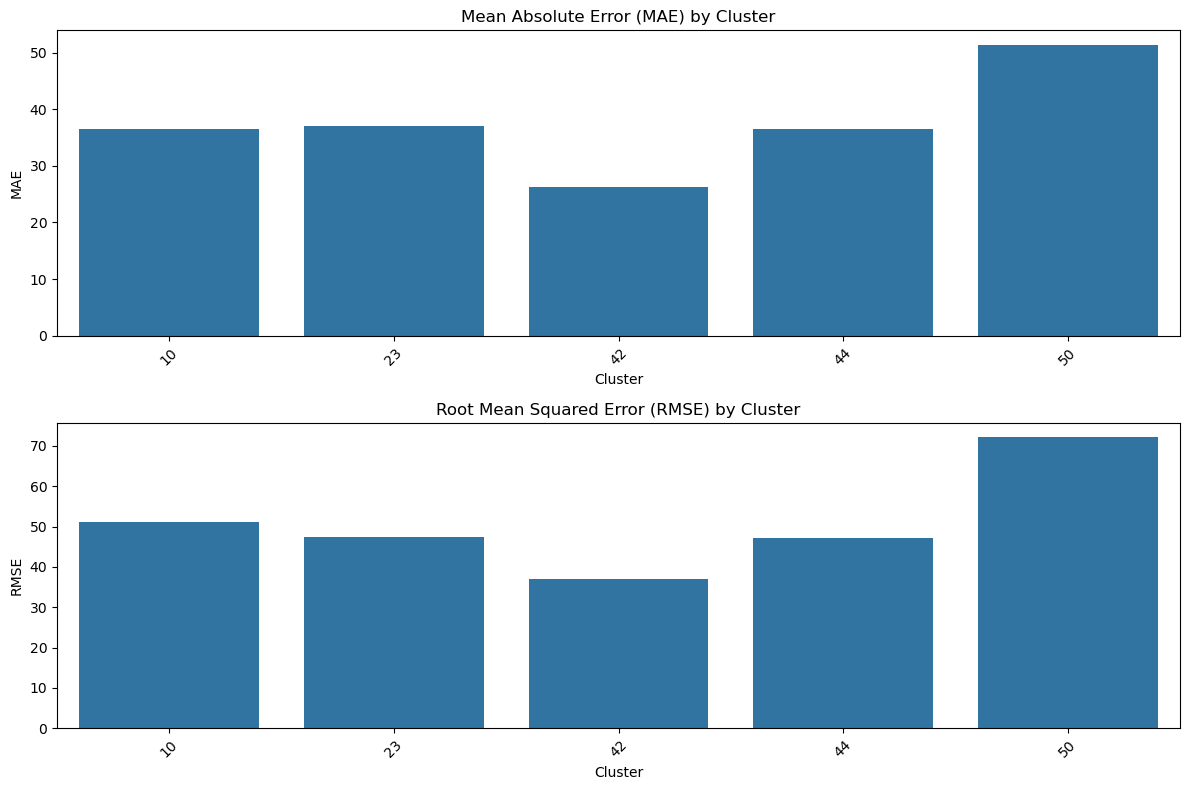

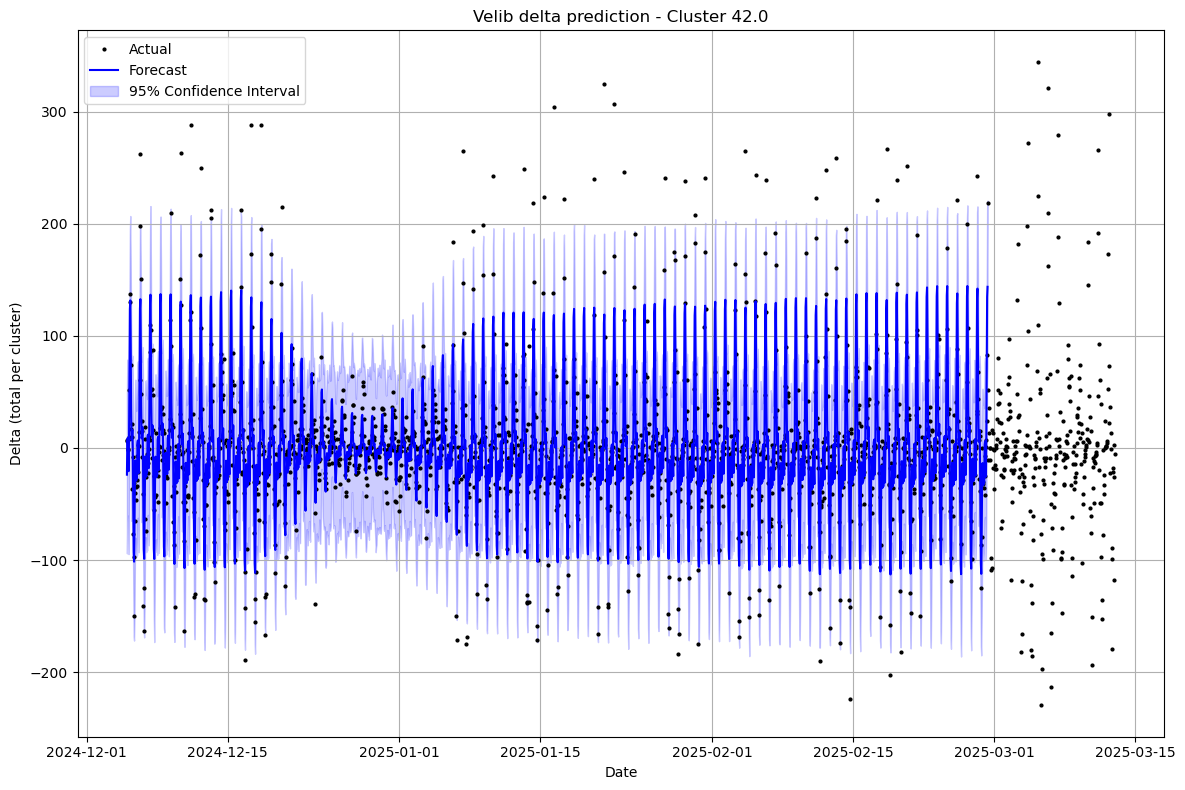

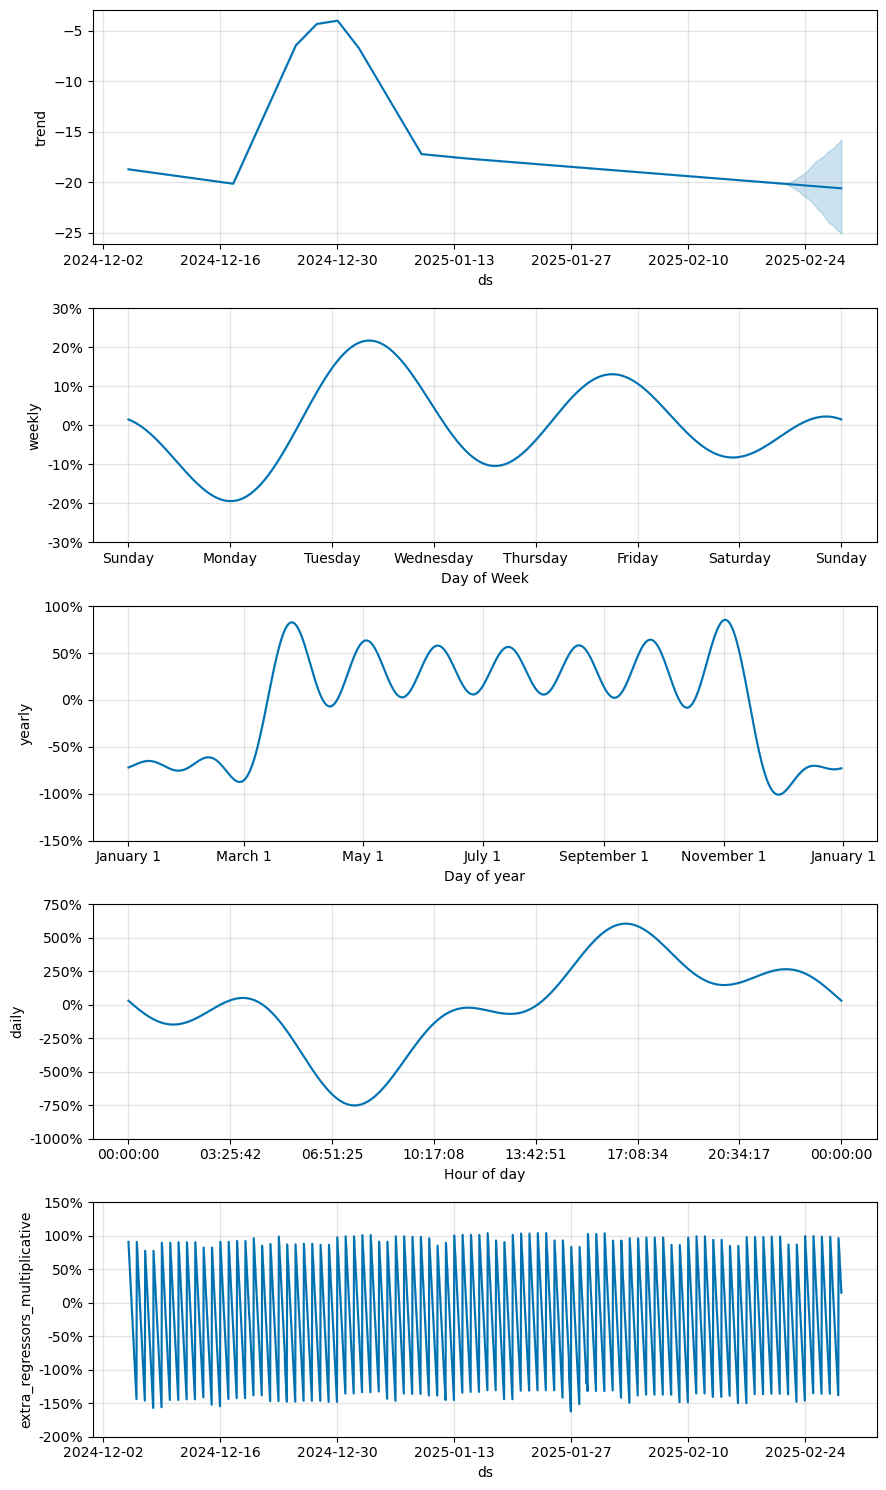

In [21]:
# Train models for the top 5 most active clusters
results = train_multiple_clusters(df_prophet, top_n=5)

# Compare performances
performance_plot, metrics_df = compare_model_performance(results)
performance_plot.savefig('../results/comparison_cluster_performances.png')

# For the best-performing cluster, visualize predictions and components
best_cluster = metrics_df.iloc[0]['Cluster']
best_model = results[best_cluster]['model']
best_forecast = results[best_cluster]['forecast']

# Visualize predictions
df_best_cluster = df_prophet[df_prophet['cluster'] == best_cluster]
prediction_plot = plot_predictions(df_best_cluster, best_forecast, best_cluster)
prediction_plot.savefig(f'../results/predictions_cluster_{best_cluster}.png')

# Analyze model components
components_plot = analyze_components(best_model, best_forecast)
components_plot.savefig(f'../results/components_cluster_{best_cluster}.png')

print("Analysis completed successfully!")
